<a href="https://colab.research.google.com/github/claudiamoses/DataScience-Class-Projects/blob/main/Copy_of_DATASCI_112_Lab_3B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Authorship Models

In Part A of this lab, you built a simple model to predict the authorship of the 15 disputed Federalist Papers.

In Part B, you will try out different models and compare them.

## Question 0

In Part A, you saved the term-frequency matrix for the Federalist Papers as a CSV file. Upload this file to the Colab runtime and read it in.

_Do not recreate the term-frequency matrix from scratch!_

In [ ]:
# Import file and get rid of weird columns
import pandas as pd
tf_df = pd.read_csv('/content/FederalistPapersAuthorship.csv').drop("Unnamed: 0", axis="columns")

## Question 1a

In the first part of this lab, you attributed each disputed document to the author of the closest document with _known_ authorship. How accurate are these attributions? There's no way to know for certain because we don't know who wrote the disputed documents (by definition!).

Let's measure the performance of this model a different way. For each document with _known_ authorship, find the closest (other) document with _known_ authorship. How often was this closest document written by the same author? Report this as a proportion. This proportion is called the **accuracy**.

In [ ]:
# Copy code from last lab for calculating best estimate for author

# Create dataframes for each author's work
authors_df = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv")
hamilton_df = authors_df.loc[authors_df["Author"] == "Hamilton"].reset_index()
jay_df = authors_df.loc[authors_df["Author"] == "Jay"].reset_index()
madison_df = authors_df.loc[authors_df["Author"] == "Madison"].reset_index()
madison_df

# Create a list of indices for each author
hamilton_paper_indices = list(hamilton_df["index"])
jay_paper_indices = list(jay_df["index"])
madison_paper_indices = list(madison_df["index"])

#create a df for known authorship
undisputed_indices = hamilton_paper_indices + jay_paper_indices + madison_paper_indices
undisputed_df = authors_df.iloc[undisputed_indices].reset_index()

#create undisputed tf matrix
undisputed_papers = tf_df.iloc[undisputed_indices]

In [ ]:
#create array of closest undisputed papers to each disputed paper
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
import numpy as np

vec = TfidfVectorizer()
vec.fit(undisputed_papers)
vec.transform(undisputed_papers)

#create matrix where we max out the diagonals so that papers will not be paired with themselves,
#and return new smallest distance
undisputed_pairs_matrix = pairwise_distances(undisputed_papers, undisputed_papers,
                                      metric="cosine")
np.fill_diagonal(undisputed_pairs_matrix, np.inf)
undisputed_pairs = undisputed_pairs_matrix.argmin(axis=1)

In [ ]:
#create mapping from each undisputed paper to a predicted author
undisputed_df["Predicted Author"] = [undisputed_df.loc[index, "Author"] for index in undisputed_pairs]

In [ ]:
# calculate frequency with which "Author" column matched "Predicted Author" column
undisputed_df["Correct Prediction"] = undisputed_df["Author"] == undisputed_df["Predicted Author"]
accuracy = undisputed_df["Correct Prediction"].sum() / len(undisputed_df)
accuracy

0.9142857142857143

_YOUR INTERPRETATION HERE_

It appears that the algorithm predicted the author of each paper with 91.4% accuracy.

## Question 1b

Using the attributed authors and actual authors from above, create a **confusion matrix**.

- A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix#Confusion_matrices_with_more_than_two_categories) counts how often a model predicts a class vs. how often the observation was actually in that class.
- In our case, we have 3 classes, Hamilton, Jay, or Madison, so the confusion matrix is $3\times 3$. The confusion matrix counts how often the model attributes Hamilton, Jay, or Madison (based on the closest document) vs. how often the document was actually written by Hamilton, Jay, or Madison.
- You can create a confusion matrix using [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), but it's also not difficult to create it from scratch using Pandas operations.
- Whichever you choose, make sure your confusion matrix is nicely formatted as a `DataFrame` with labeled rows and columns.

Show how to calculate the accuracy from the confusion matrix. Make sure this agrees with the value you got above!

In [ ]:
#  Create a confusion matrix using scikit-learn
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(undisputed_df["Author"], undisputed_df["Predicted Author"])
c_matrix_df = pd.DataFrame(c_matrix, index=["Hamilton", "Jay", "Madison"],
                           columns=["Hamilton", "Jay", "Madison"])
c_matrix_df

,Hamilton,Jay,Madison
Hamilton,48,0,3
Jay,0,4,1
Madison,2,0,12


_Calculate the accuracy using the confusion matrix._

To calculate the accuracy using the confusion matrix, we need to add up all the values along the diagonal, and divide that over the total sum off all the values in the matrix. This creates a proportion of accurate estimates, which are those along the diagonal, out of all estimates in the matrix, which is the accuracy proportion. In matrix theory, the sum of the diagonals is called the trace. Here, I will use numpy to calculate the trace, and divide it by the total sum of values in the confusion matrix.

In [ ]:
# execute the above formula
correct_predictions = np.trace(c_matrix)
total_predictions = c_matrix.sum()
c_matrix_accuracy = correct_predictions / total_predictions
c_matrix_accuracy

0.9142857142857143

Here again we get an accuracy of 91.4%, which is the same accuracy we calculated above.

## Question 2

Instead of attributing each document to the author of the closest other document, suppose that we base the attribution on the authors of the $k$ closest other documents by "voting". (For example, if 3
of the $k=5$ closest documents were written by Hamilton, 1 by Madison, and 1 by Jay, then we would attribute that document to Hamilton.)

Let's first try this on documents with _known_ authorship. For different values of $k$:

- determine the attribution of each document based on the $k$ closest other documents
- calculate the accuracy.

Make a line graph showing the accuracy as a function of $k$. Which value of $k$ is best?

[_Note:_ You are not allowed to use `sklearn.neighbors.KNeighborsClassifier` to do this exercise!]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def find_accuracy(k):
  # find k-nearest neighbors on our undisputed_pairs_matrix from earlier
  undisputed_pairs = np.argsort(undisputed_pairs_matrix, axis=1)[:, :k]

  # find each k-group's most common authors and create a list
  undisputed_pairs_authors = pd.Series(undisputed_df.loc[index, "Author"] for index in undisputed_pairs)
  undisputed_pairs_authors_mode = pd.Series(index.mode().iat[0] for index in undisputed_pairs_authors)
  undisputed_pairs_authors_mode = undisputed_pairs_authors_mode.tolist()

  # put new list into df and calculate accuracy
  undisputed_df_2 = undisputed_df
  undisputed_df_2["Predicted Author"] = undisputed_pairs_authors_mode
  undisputed_df_2["Correct Prediction"] = undisputed_df_2["Author"] == undisputed_df_2["Predicted Author"]
  accuracy = undisputed_df_2["Correct Prediction"].sum() / len(undisputed_df_2)
  return accuracy

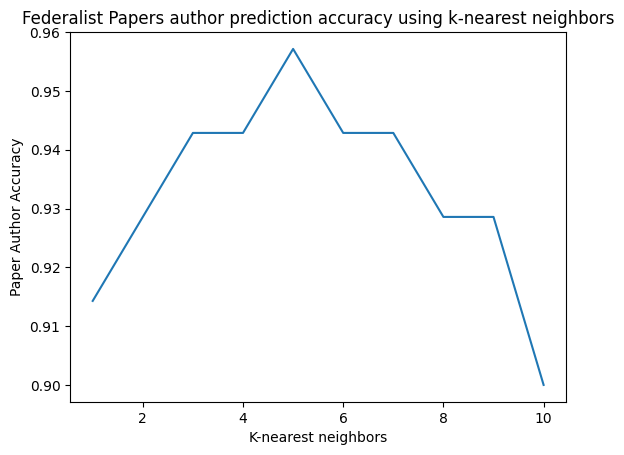

In [ ]:
# graph accuracy by value
x_values = []
y_values = []

for i in range(1, 11):
  x_values.append(i)
  y_values.append(find_accuracy(i))

plt.plot(x_values, y_values, linestyle="-")
plt.xlabel("K-nearest neighbors")
plt.ylabel("Paper Author Accuracy")
plt.title("Federalist Papers author prediction accuracy using k-nearest neighbors")
plt.show()

_Which value of $k$ is best?_

Based on the peak in the graph, we can see that using a k-value of 5, or the 5 nearest neighbors, returns the most accurate estimate at around 95.8%.

## Question 3

Now, use the best value of $k$ that you found in Question 2, and attribute the _disputed_ documents based on the $k$ closest documents with _known_ authorship.

In [ ]:
# Use methodology from last few questions:)
disputed_df = authors_df[pd.isna(authors_df["Author"])].reset_index()
disputed_indices = list(disputed_df["index"])
disputed_papers = tf_df.iloc[disputed_indices]

#create array of closest undisputed papers to each disputed paper
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
import numpy as np

vec = TfidfVectorizer()
vec.fit(disputed_papers)
vec.transform(disputed_papers)

vec.fit(undisputed_papers)
vec.transform(undisputed_papers)

#create distance matrix
disputed_pairs_matrix = pairwise_distances(disputed_papers, undisputed_papers,
                                      metric="cosine")

# find k-nearest neighbors on our matrix
disputed_pairs = np.argsort(disputed_pairs_matrix, axis=1)[:, :5]

# find each 5-group's most common authors and create a list
disputed_pairs_authors = pd.Series(undisputed_df.loc[index, "Author"] for index in disputed_pairs)
disputed_pairs_authors_mode = pd.Series(index.mode().iat[0] for index in disputed_pairs_authors)
disputed_pairs_authors_mode = disputed_pairs_authors_mode.tolist()


# put new list into df
disputed_df_2 = disputed_df
disputed_df_2["Predicted Author"] = disputed_pairs_authors_mode
disputed_df_2

,index,Paper,Author,Predicted Author
0,17,18,NaN,Madison
1,18,19,NaN,Madison
2,19,20,NaN,Madison
3,48,49,NaN,Hamilton
4,49,50,NaN,Madison
5,50,51,NaN,Madison
6,51,52,NaN,Hamilton
7,52,53,NaN,Madison
8,53,54,NaN,Madison
9,54,55,NaN,Hamilton


_YOUR CONCLUSION HERE_

With this new method, I get the above predictions as to who wrote each disputed paper. The 5-nearest neighbors of each disputed paper appear to be very different than the predicted outcomes from the first part of the lab, just based off of the 1-nearest neighbor (aka the most similar paper). We can see that John Jay gets a lot less credit, and Madison gets a lot more with this new method. I also notice that authors are a lot less clustered by index with this new method.

## Submission Instructions

- Restart this notebook and run the cells from beginning to end.
  - Go to Runtime > Restart and Run All.

In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html --log-level WARN _NOTEBOOK.ipynb

# Download the .html file.
google.colab.files.download("_NOTEBOOK.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Open `_NOTEBOOK.html` in your browser, and save it as a PDF.
    - Go to File > Print > Save as PDF.
- Double check that all of your code and output is visible in the saved PDF.
- Upload the PDF to [Gradescope](https://www.gradescope.com/courses/694907).
    - Please be sure to select the correct pages corresponding to each question.